# Modeling — Predicting 30-Day Hospital Readmission

**Goal:**  
Build and evaluate machine learning models to predict whether a patient will be readmitted to the hospital within 30 days of discharge, using the cleaned dataset.

**Key steps in this notebook:**
1. **Load cleaned dataset**.
2. **Separate features & target** (`readmit_30`).
3. **Remove identifiers and leakage columns**.
4. **Preprocess features**:
   - One-Hot Encode categorical variables.
   - Scale numeric features for linear models.
5. **Split data** using stratification to maintain class balance.
6. **Baseline models**:
   - Logistic Regression (`class_weight='balanced'`)
   - Random Forest (`class_weight='balanced_subsample'`)
7. **Evaluate models** using ROC AUC and Precision-Recall AUC.
8. **Tune decision threshold** to balance recall and precision.
9. **Save trained models** for future use (e.g., dashboard or app).

**Why this matters:**
Accurately identifying high-risk patients for 30-day readmission can help hospitals target interventions, reduce costs, and improve patient outcomes.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib



(101766, 48)
X shape: (101766, 44) y positive rate: 0.1116
Categorical: 33 | Numeric: 11
LR ROC AUC: 0.6444
LR PR AUC (AP): 0.2046
Best F1 threshold: 0.5633 F1: 0.2649
Threshold for ~60% recall: 0.4794 Recall: 0.6002 Precision: 0.1598

Classification report @ best F1 threshold
              precision    recall  f1-score   support

           0      0.914     0.789     0.847     18083
           1      0.196     0.409     0.265      2271

    accuracy                          0.747     20354
   macro avg      0.555     0.599     0.556     20354
weighted avg      0.834     0.747     0.782     20354

Confusion matrix @ best F1 threshold
[[14275  3808]
 [ 1343   928]]
RF ROC AUC: 0.6758
RF PR AUC (AP): 0.2193


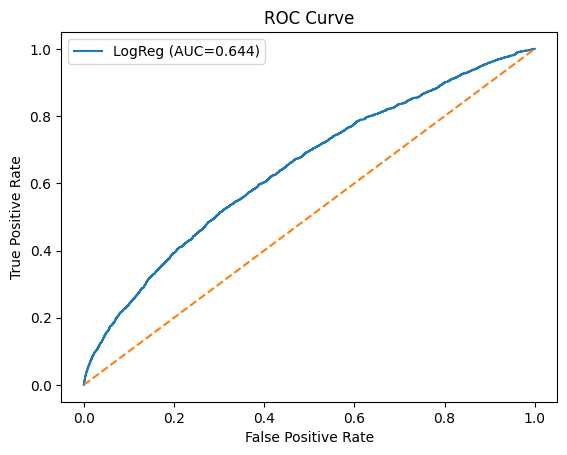

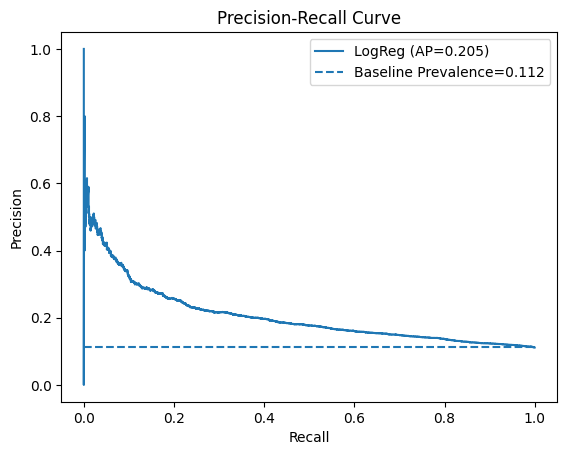

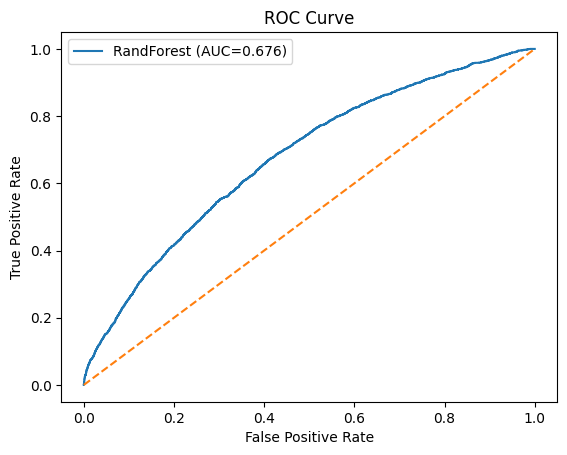

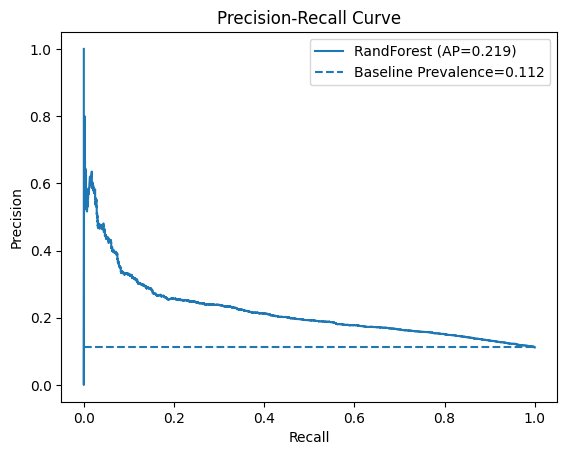

Saved models to artifacts/


In [2]:

# Load the cleaned dataset 
clean_path = Path("../data/diabetic_data_clean.csv")
df_clean = pd.read_csv(clean_path)

# Work on a modeling copy so df_clean stays pristine
df_model = df_clean.copy()

print(df_model.shape)
df_model.head(3)


TARGET = 'readmit_30'

# IDs / high-risk leakage columns to drop from features:
# - encounter_id & patient_nbr are unique IDs (no predictive value)
# - readmitted is the raw multi-class label we derived target from
id_or_leak_cols = [c for c in ['encounter_id','patient_nbr','readmitted'] if c in df_model.columns]

X = df_model.drop(columns=id_or_leak_cols + [TARGET])
y = df_model[TARGET]

print("X shape:", X.shape, "y positive rate:", y.mean().round(4))

# Column typing & encoders

# Identify column types
cat_cols = X.select_dtypes(include='object').columns.tolist()
num_cols = X.select_dtypes(exclude='object').columns.tolist()

print("Categorical:", len(cat_cols), "| Numeric:", len(num_cols))

# Build preprocessors
categorical = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
numeric = StandardScaler(with_mean=False)  # with_mean=False because we may use sparse matrices

preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical, cat_cols),
        ('num', numeric, num_cols),
    ],
    remainder='drop',
    sparse_threshold=1.0
)

# Stratified split because of imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape, y_train.mean().round(4), y_test.mean().round(4)

model_lr = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
])

model_lr.fit(X_train, y_train)

proba_lr = model_lr.predict_proba(X_test)[:,1]
print("LR ROC AUC:", round(float(roc_auc_score(y_test, proba_lr)), 4))
print("LR PR AUC (AP):", round(float(average_precision_score(y_test, proba_lr)), 4))


prec, rec, thr = precision_recall_curve(y_test, proba_lr)

# Strategy A: maximize F1
f1s = []
for t in thr:
    yhat = (proba_lr >= t).astype(int)
    f1s.append(f1_score(y_test, yhat))
best_idx = int(np.argmax(f1s))
best_thr_f1 = thr[best_idx]
print("Best F1 threshold:", round(float(best_thr_f1), 4), "F1:", round(float(np.max(f1s)),4))

# Strategy B (optional): pick threshold for desired recall (e.g., ~0.60)
target_recall = 0.60
rec_idx = np.argmin(np.abs(rec[:-1] - target_recall))
thr_recall = thr[rec_idx]
print("Threshold for ~60% recall:", round(float(thr_recall),4), "Recall:", round(float(rec[rec_idx]),4), "Precision:", round(float(prec[rec_idx]),4))

# Evaluate at best F1 threshold
yhat_best = (proba_lr >= best_thr_f1).astype(int)
print("\nClassification report @ best F1 threshold")
print(classification_report(y_test, yhat_best, digits=3))

print("Confusion matrix @ best F1 threshold")
print(confusion_matrix(y_test, yhat_best))

model_rf = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

model_rf.fit(X_train, y_train)
proba_rf = model_rf.predict_proba(X_test)[:,1]
print("RF ROC AUC:", round(float(roc_auc_score(y_test, proba_rf)), 4))
print("RF PR AUC (AP):", round(float(average_precision_score(y_test, proba_rf)), 4))

def plot_roc_pr(y_true, proba, label):
    fpr, tpr, _ = roc_curve(y_true, proba)
    roc_auc = auc(fpr, tpr)

    prec, rec, _ = precision_recall_curve(y_true, proba)
    ap = average_precision_score(y_true, proba)

    # ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f'{label} (AUC={roc_auc:.3f})')
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    # PR
    plt.figure()
    plt.plot(rec, prec, label=f'{label} (AP={ap:.3f})')
    baseline = y_true.mean()
    plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline Prevalence={baseline:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

plot_roc_pr(y_test, proba_lr, "LogReg")
plot_roc_pr(y_test, proba_rf, "RandForest")

artifacts_dir = Path("artifacts")
artifacts_dir.mkdir(exist_ok=True)

joblib.dump(model_lr, artifacts_dir / "model_lr.joblib")
joblib.dump(model_rf, artifacts_dir / "model_rf.joblib")

print("Saved models to artifacts/")


